### **Final Version**

Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/overlay_ALL_transforms_alpha_0.00.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/faceted_by_transform_alpha_0.00.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/overlay_ALL_transforms_alpha_0.25.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/faceted_by_transform_alpha_0.25.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/overlay_ALL_transforms_alpha_0.50.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/faceted_by_transform_alpha_0.50.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/overlay_ALL_transforms_alpha_0.75.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha/faceted_by_transform_alpha_0.75.png 
Saved: /content/drive/MyDrive/1_First_Paper/Long

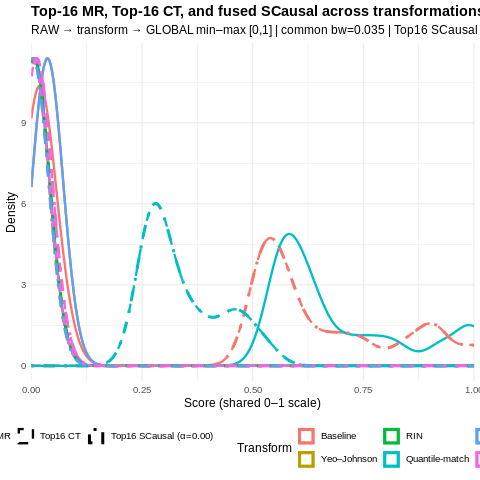

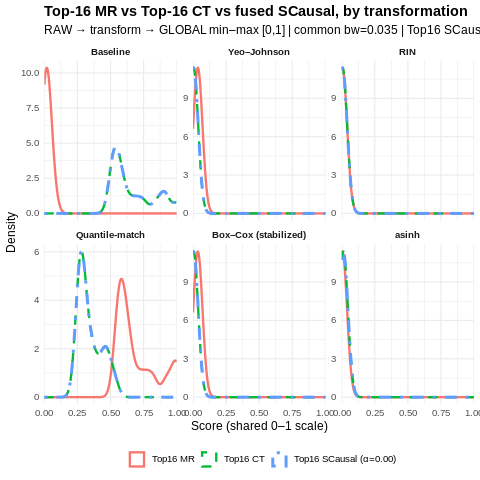

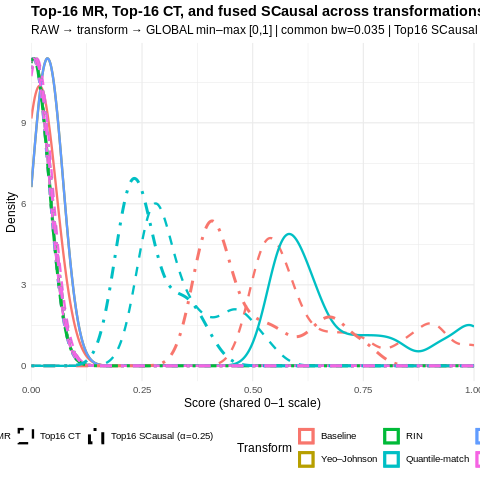

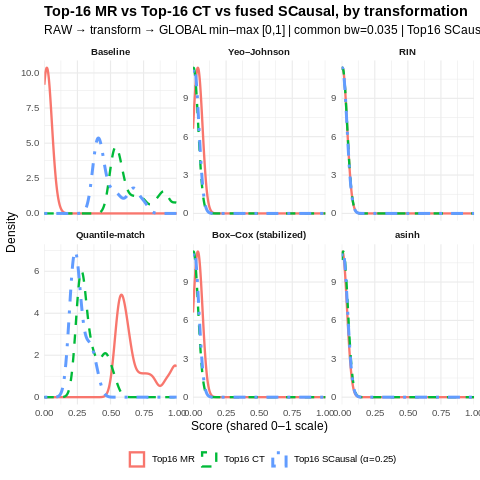

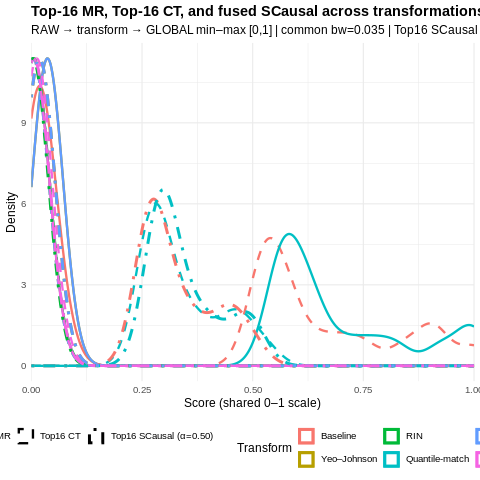

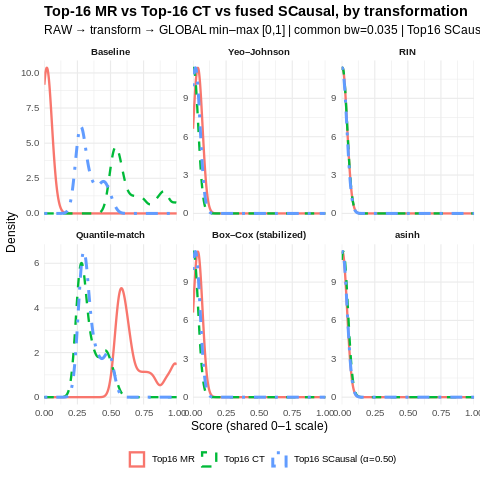

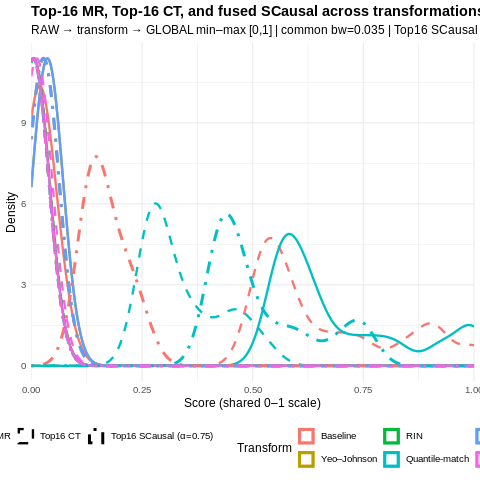

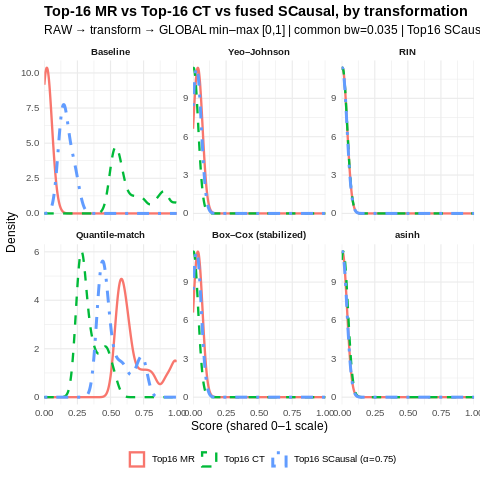

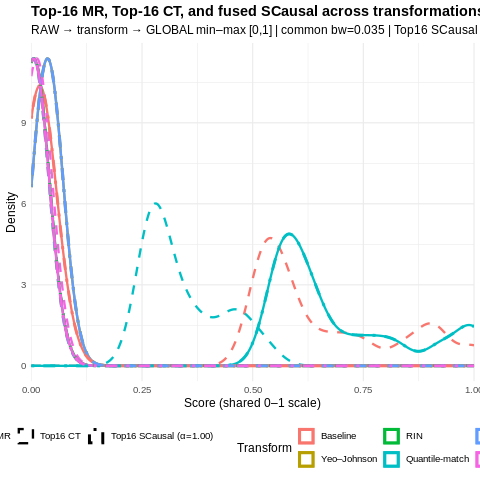

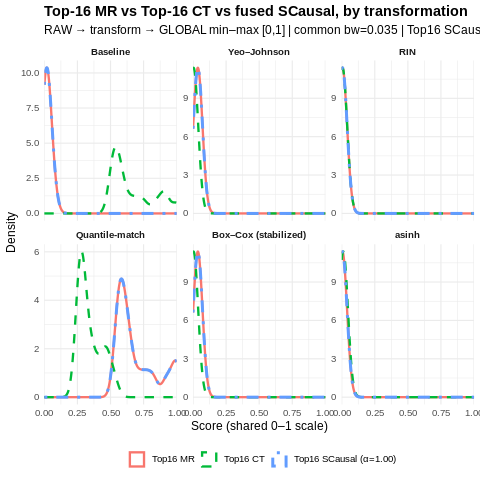

In [ ]:
%%R
# ==========================================================
# Comparable x-axes across transforms + separate plots per α
# RAW -> transform -> GLOBAL min–max [0,1] (shared per-modality)
# Top-16 MR, CT, and fused SCausal curves with visible overlaps
# ==========================================================
req <- c("data.table","dplyr","ggplot2","readr","bestNormalize")
to_install <- setdiff(req, rownames(installed.packages()))
if (length(to_install)) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

# ---------- SETTINGS ----------
file    <- "/content/drive/MyDrive/1_First_Paper/Long_COVID/final_results/GitHub/Final/mt_robin_CT.csv"
methods <- c("none","yeo-johnson","rin","quantile-match","box-cox","asinh")
labels_map  <- c("none"="Baseline",
                 "yeo-johnson"="Yeo–Johnson",
                 "rin"="RIN",
                 "quantile-match"="Quantile-match",
                 "box-cox"="Box–Cox (stabilized)",
                 "asinh"="asinh")
ALPHAS  <- c(0.00, 0.25, 0.50, 0.75, 1.00)
top_n   <- 16
out_dir <- "/content/drive/MyDrive/1_First_Paper/Long_COVID/Review/Distribution_Alpha"
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# Plot + display toggles
USE_COMMON_BW <- TRUE                      # common KDE bandwidth
EXCLUDE_BOXCox_FROM_OVERLAY <- FALSE       # hide Box–Cox in overlay if TRUE
SHOW_RUGS <- FALSE                         # add rugs at the bottom
DROP_REDUNDANT_SCAUSAL_AT_EXTREMES <- FALSE# if TRUE, hide SCausal when α∈{0,1}

# ---------- HELPERS ----------
minmax_global <- function(x, gmin, gmax){
  (x - gmin) / (gmax - gmin + 1e-12)
}
rin <- function(x){
  r <- rank(x, ties.method="average", na.last="keep")
  qnorm((r - 0.5) / sum(!is.na(r)))
}
boxcox_stabilized <- function(x){
  eps <- 1e-6
  x_pos <- x - min(x, na.rm=TRUE) + eps
  bx    <- bestNormalize::boxcox(x_pos, standardize = FALSE)
  as.numeric(scale(as.numeric(predict(bx))))
}
# Transform RAW scores (no scaling here)
transform_pair_raw <- function(mr_raw, ct_raw,
                               method=c("none","yeo-johnson","rin","quantile-match","box-cox","asinh")){
  method <- match.arg(method)
  mr_fin <- is.finite(mr_raw); ct_fin <- is.finite(ct_raw)
  if (method=="none"){
    mr_u <- mr_raw; ct_u <- ct_raw
  } else if (method=="yeo-johnson"){
    mr_u <- rep(NA_real_, length(mr_raw)); mr_u[mr_fin] <- predict(bestNormalize::yeojohnson(mr_raw[mr_fin]))
    ct_u <- rep(NA_real_, length(ct_raw)); ct_u[ct_fin] <- predict(bestNormalize::yeojohnson(ct_raw[ct_fin]))
  } else if (method=="rin"){
    mr_u <- rin(mr_raw); ct_u <- rin(ct_raw)
  } else if (method=="quantile-match"){
    # Symmetric alignment of distributions
    ct_sorted <- sort(ct_raw, na.last=NA)
    mr_rank <- rank(mr_raw, ties.method="average", na.last="keep")/(sum(is.finite(mr_raw))+1)
    mr_u <- rep(NA_real_, length(mr_raw)); mr_u[mr_fin] <- stats::quantile(ct_sorted, probs=mr_rank[mr_fin], na.rm=TRUE, type=7)

    mr_sorted <- sort(mr_raw, na.last=NA)
    ct_rank <- rank(ct_raw, ties.method="average", na.last="keep")/(sum(is.finite(ct_raw))+1)
    ct_u_alt <- rep(NA_real_, length(ct_raw)); ct_u_alt[ct_fin] <- stats::quantile(mr_sorted, probs=ct_rank[ct_fin], na.rm=TRUE, type=7)
    ct_u <- (ct_raw + ct_u_alt)/2
  } else if (method=="box-cox"){
    mr_u <- boxcox_stabilized(mr_raw)
    ct_u <- boxcox_stabilized(ct_raw)
  } else if (method=="asinh"){
    mr_u <- asinh(mr_raw); ct_u <- asinh(ct_raw)
  }
  list(mr_u=mr_u, ct_u=ct_u)
}

# ---------- LOAD & CHOOSE RAW COLUMNS ----------
df <- data.table::fread(file)

get_mr_raw <- function(d){
  nm <- tolower(names(d))
  for (c in c("mr_score","srisk","mr")) {
    j <- match(c, nm, nomatch = 0); if (j > 0) return(d[[j]])
  }
  for (c in c("mr_score_norm","srisk_norm")) {      # fallback
    j <- match(c, nm, nomatch = 0); if (j > 0) return(d[[j]])
  }
  stop("No MR raw-like column found (mr_score/srisk/mr).")
}
get_ct_raw <- function(d){
  nm <- tolower(names(d))
  for (c in c("ct_score","snetwork","ct","k")) {
    j <- match(c, nm, nomatch = 0); if (j > 0) return(d[[j]])
  }
  if (all(c("k","typei","typeii") %in% nm)){        # derive from K*W
    W <- ifelse(d[[match("typeii", nm)]]==0, 2L,
         ifelse(d[[match("typei", nm)]]==0, 1L, 0L))
    return(d[[match("k", nm)]] * W)
  }
  jn <- match("ct_score_norm", nm, nomatch = 0)
  if (jn > 0) return(d[[jn]])
  stop("No CT raw-like column found (ct_score/snetwork/ct/k or K*W).")
}
mr_raw <- get_mr_raw(df)
ct_raw <- get_ct_raw(df)

# ---------- 1) TRANSFORM (raw) FOR ALL METHODS ----------
raw_bank <- lapply(methods, function(m){
  tr <- transform_pair_raw(mr_raw, ct_raw, method=m)
  tr$MethodKey <- m
  tr
})
names(raw_bank) <- methods

# ---------- 2) GLOBAL MIN/MAX (shared scale per modality) ----------
mr_all <- unlist(lapply(raw_bank, `[[`, "mr_u"))
ct_all <- unlist(lapply(raw_bank, `[[`, "ct_u"))
mr_gmin <- min(mr_all, na.rm=TRUE); mr_gmax <- max(mr_all, na.rm=TRUE)
ct_gmin <- min(ct_all, na.rm=TRUE); ct_gmax <- max(ct_all, na.rm=TRUE)

# ---------- 3) SCALE EVERY METHOD WITH THE SAME GLOBAL LIMITS ----------
scaled_bank <- lapply(raw_bank, function(tr){
  list(
    MethodKey = tr$MethodKey,
    mr_scaled = minmax_global(tr$mr_u, mr_gmin, mr_gmax),
    ct_scaled = minmax_global(tr$ct_u, ct_gmin, ct_gmax)
  )
})
names(scaled_bank) <- methods

# ---------- COMMON BANDWIDTH ----------
scores_for_bw <- unlist(lapply(scaled_bank, function(x) c(x$mr_scaled, x$ct_scaled)))
common_bw <- try(suppressWarnings(stats::bw.SJ(scores_for_bw[is.finite(scores_for_bw)])), silent=TRUE)
if (!is.numeric(common_bw) || is.na(common_bw)) common_bw <- 0.06
common_bw <- max(0.035, min(0.10, common_bw))

# ---------- PLOTTING (separate files per α) ----------
for (ALPHA_SELECTED in ALPHAS) {

  # Build plotting frame
  plot_rows <- list()
  for (m in methods){
    tr <- scaled_bank[[m]]

    # Top-N by modality
    ord_mr <- order(tr$mr_scaled, decreasing=TRUE, na.last=TRUE)
    ord_ct <- order(tr$ct_scaled, decreasing=TRUE, na.last=TRUE)
    idx_mr <- ord_mr[seq_len(min(top_n, length(ord_mr)))]
    idx_ct <- ord_ct[seq_len(min(top_n, length(ord_ct)))]

    rows <- data.frame(
      Score      = c(tr$mr_scaled[idx_mr], tr$ct_scaled[idx_ct]),
      Component  = factor(rep(c("Top16 MR","Top16 CT"),
                              times=c(length(idx_mr), length(idx_ct))),
                          levels=c("Top16 MR","Top16 CT")),
      MethodKey  = m,
      Transform  = labels_map[m],
      stringsAsFactors = FALSE
    )

    # Fused SCausal for this α
    sc <- ALPHA_SELECTED * tr$mr_scaled + (1 - ALPHA_SELECTED) * tr$ct_scaled
    ord_sc <- order(sc, decreasing=TRUE, na.last=TRUE)
    idx_sc <- ord_sc[seq_len(min(top_n, length(ord_sc)))]
    sc_lab <- sprintf("Top16 SCausal (α=%.2f)", ALPHA_SELECTED)
    rows <- rbind(
      rows,
      data.frame(
        Score      = sc[idx_sc],
        Component  = factor(sc_lab, levels=c("Top16 MR","Top16 CT", sc_lab)),
        MethodKey  = m,
        Transform  = labels_map[m],
        stringsAsFactors = FALSE
      )
    )

    plot_rows[[length(plot_rows)+1]] <- rows
  }
  plot_df <- dplyr::bind_rows(plot_rows)
  plot_df$Transform <- factor(plot_df$Transform, levels=labels_map[methods])

  # Optionally drop redundant SCausal at extremes (α=0 or α=1)
  sc_lab <- sprintf("Top16 SCausal (α=%.2f)", ALPHA_SELECTED)
  if (DROP_REDUNDANT_SCAUSAL_AT_EXTREMES && (ALPHA_SELECTED <= 1e-6 || ALPHA_SELECTED >= 1-1e-6)) {
    plot_df <- subset(plot_df, Component != sc_lab)
  }

  # Split for drawing SCausal on top (clearer overlaps)
  base_df <- subset(plot_df, Component != sc_lab)
  sc_df   <- subset(plot_df, Component == sc_lab)

  # Linetype/alpha aesthetics
  lt_vals <- c("Top16 MR"="solid", "Top16 CT"="dashed", setNames("dotdash", sc_lab))
  a_vals  <- c("Top16 MR"=0.85,   "Top16 CT"=0.85,   setNames(1.0, sc_lab))

  # ---------- OVERLAY (all transforms together) ----------
  overlay_df <- base_df
  if (EXCLUDE_BOXCox_FROM_OVERLAY) {
    overlay_df <- subset(overlay_df, MethodKey != "box-cox")
    sc_df      <- subset(sc_df,      MethodKey != "box-cox")
  }

  p1 <- ggplot(overlay_df, aes(x=Score, color=Transform, linetype=Component, alpha=Component)) +
    { if (USE_COMMON_BW) geom_density(bw=common_bw, linewidth=1.1, na.rm=TRUE)
      else               geom_density(adjust=1.8, linewidth=1.1, na.rm=TRUE) } +
    # draw SCausal on top
    { if (nrow(sc_df)) geom_density(data=sc_df, aes(x=Score, color=Transform, linetype=Component),
                                    linewidth=1.4, alpha=1.0,
                                    bw = if (USE_COMMON_BW) common_bw else NULL, na.rm=TRUE) } +
    scale_x_continuous(limits=c(0,1), breaks=seq(0,1,0.25), expand=c(0,0)) +
    scale_linetype_manual(values=lt_vals) +
    scale_alpha_manual(values=a_vals, guide="none") +
    labs(
      title    = "Top-16 MR, Top-16 CT, and fused SCausal across transformations",
      subtitle = sprintf("RAW → transform → GLOBAL min–max [0,1] | common bw=%.3f | %s",
                         common_bw, sc_lab),
      x = "Score (shared 0–1 scale)", y = "Density",
      color = "Transform", linetype = "Set"
    ) +
    theme_minimal(base_size=12) +
    theme(legend.position="bottom", plot.title=element_text(face="bold"))
  if (SHOW_RUGS) p1 <- p1 + geom_rug(data=plot_df, aes(x=Score, color=Transform), sides="b", alpha=0.2)

  fn1 <- file.path(out_dir, sprintf("overlay_ALL_transforms_alpha_%0.2f.png", ALPHA_SELECTED))
  ggsave(fn1, p1, width=11, height=6.2, dpi=300)
  print(p1); cat("Saved:", fn1, "\n")

  # ---------- FACETED (one panel per transform) ----------
  p2 <- ggplot(base_df, aes(x=Score, color=Component, linetype=Component, alpha=Component)) +
    { if (USE_COMMON_BW) geom_density(bw=common_bw, linewidth=1.1, na.rm=TRUE)
      else               geom_density(adjust=1.9, linewidth=1.1, na.rm=TRUE) } +
    { if (nrow(sc_df)) geom_density(data=sc_df, aes(x=Score, color=Component, linetype=Component),
                                    linewidth=1.4, alpha=1.0,
                                    bw = if (USE_COMMON_BW) common_bw else NULL, na.rm=TRUE) } +
    facet_wrap(~ Transform, ncol=3, scales="free_y") +
    scale_x_continuous(limits=c(0,1), breaks=seq(0,1,0.25), expand=c(0,0)) +
    scale_linetype_manual(values=lt_vals) +
    scale_alpha_manual(values=a_vals, guide="none") +
    labs(
      title    = "Top-16 MR vs Top-16 CT vs fused SCausal, by transformation",
      subtitle = sprintf("RAW → transform → GLOBAL min–max [0,1] | common bw=%.3f | %s",
                         common_bw, sc_lab),
      x = "Score (shared 0–1 scale)", y = "Density", color = "", linetype = ""
    ) +
    theme_minimal(base_size=12) +
    theme(legend.position="bottom", plot.title=element_text(face="bold"),
          strip.text=element_text(face="bold"))
  if (SHOW_RUGS) p2 <- p2 + geom_rug(data=plot_df, aes(x=Score, color=Component), sides="b", alpha=0.25)

  fn2 <- file.path(out_dir, sprintf("faceted_by_transform_alpha_%0.2f.png", ALPHA_SELECTED))
  ggsave(fn2, p2, width=13, height=7.5, dpi=300)
  print(p2); cat("Saved:", fn2, "\n")
}